# Estimating Parameter Confidence Intervals With Bootstrapping
This notebook demonstrates the calculations required to do confidence interval constructions.
1. Construct a good model. This means checking that we get good $R^2$ values (or other model quality metrics) for each fold in a cross validation.
1. Compute residuals for the good model.
1. Construct a collection of parameter estimates. That is, for many repetitions
   1. Construct new observations (by using randomly selected residuals)
   1. Estimate parameter values
1. Compute the mean and standard deviation of the parameter estimates
1. Construct the confidence interval

In [1]:
%matplotlib inline
import tellurium as te
import numpy as np
import lmfit   # Fitting lib
import math
import random 
import matplotlib.pyplot as plt
import model_fitting as mf

In [2]:
# Model used in this example
model = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""
unfitted_parameters = mf.makeParameters(constants=['k1', 'k2'])
unfitted_parameters

name,value,initial value,min,max,vary
k1,1.00000000,1,0.00000000,10.0000000,True
k2,1.00000000,1,0.00000000,10.0000000,True


In [8]:
# Globals
num_points = 15
sim_time = 30
noise_std = 0.5

In [9]:
# Create synthetic observational data for this example. This is for demonstration purposes only.
# In practice, you will have observational data from experiments.
obs_data = mf.makeObservations(model=model, noise_std=noise_std, num_points=num_points, sim_time=sim_time)
obs_data

       time,      [A],       [B],       [C]
 [[       0,  5.19429,         0,  0.334758],
  [ 2.14286,  4.01226,    1.0914,  0.995395],
  [ 4.28571,  3.26523,   1.25035, 0.0286604],
  [ 6.42857,  2.71896,   1.01837,   1.62184],
  [ 8.57143,  2.51045,   1.46637,   1.31101],
  [ 10.7143,  1.81673,  0.816018,   1.59899],
  [ 12.8571,  2.16734,  0.742242,   2.85939],
  [      15,  1.52514,   1.25302,   2.90911],
  [ 17.1429, 0.287779,  0.581976,   3.07842],
  [ 19.2857,  1.31412,  0.364865,   3.35864],
  [ 21.4286, 0.492193,  0.311783,   3.19945],
  [ 23.5714, 0.760769,  0.112157,   4.56493],
  [ 25.7143, 0.853517,  0.830255,   4.50902],
  [ 27.8571, 0.363173,  0.524012,   5.23884],
  [      30, 0.394583, 0.0617312,   4.91017]]

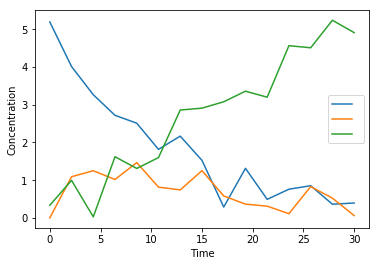

In [11]:
mf.plotTimeSeries(obs_data)

## Step 1: Construct a good model.
In the following, we use the same model as the synthetic observations. Of course, in practice, you won't know the "true" model. You'll try many, and choose the best in terms of the quality metrics (e.g., $R^2$).

In [10]:
# Do the cross validation for this model. the crossValidate function returns two values: list of
# the parameters (for each fold) and RSQs for each fold.
list_parameters, rsqs = mf.crossValidate(obs_data, model=model, parameters=unfitted_parameters, 
                                         num_points=num_points, 
                                         sim_time=sim_time,
                                         num_folds=3)
rsqs

[0.951880346237209, 0.9125707424247982, 0.9473930702638862]

In [12]:
list_parameters

[Parameters([('k1',
              <Parameter 'k1', value=0.09744795751649105 +/- 0.00702, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.18809028590274557 +/- 0.0246, bounds=[0:10]>)]),
 Parameters([('k1',
              <Parameter 'k1', value=0.08984145893237927 +/- 0.00571, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.23893394601316287 +/- 0.0344, bounds=[0:10]>)]),
 Parameters([('k1',
              <Parameter 'k1', value=0.0878078148132555 +/- 0.00618, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.21860725147638593 +/- 0.0328, bounds=[0:10]>)])]

These are very good $R^2$ values. So, we accept the model.

Next, we need to estimate the parameter values to use in our model. To this end, we do a fit on the full set of data.

In [13]:
fitted_parameters = mf.fit(obs_data, model=model, parameters=unfitted_parameters,
                           num_points=num_points, sim_time=sim_time)
fitted_parameters

name,value,standard error,relative error,initial value,min,max,vary
k1,0.09167109,0.00515201,(5.62%),1,0.00000000,10.0000000,True
k2,0.21265601,0.02449143,(11.52%),1,0.00000000,10.0000000,True


# Step 2: Compute the Residuals
Residuals need to be calculated by chemical species since they may be in very different units.

In [15]:
def makeResidualsBySpecies(obs_data, model, parameters, num_points, sim_time):
    """
    Calculate residuals for each chemical species.
    :param np.array obs_data: matrix of observations; first column is time; number of rows is num_points
    :param str model:
    :param lmfit.Parameters parameters.
    :param int num_points:
    :param int sim_time:
    :return np.array: matrix of residuals; columns are chemical species
    """
    data = mf.runSimulation(model=model, parameters=parameters, num_points=num_points, sim_time=sim_time)
    residuals = mf.calcSimulationResiduals(parameters, obs_data, num_points=num_points, sim_time=sim_time,
                                          model=model)
    # Reshape the residuals by species
    rr = te.loada(model)
    num_species = rr.getNumFloatingSpecies()
    nrows = int(len(residuals) / num_species)
    return np.reshape(residuals, (nrows, num_species))

In [16]:
# Note that the residuals for the chemical species differ. Compare the residuals for A (1st col) with
# the residuals for C (3rd col)
residuals_matrix = makeResidualsBySpecies(obs_data, model, fitted_parameters, num_points, sim_time)
residuals_matrix

 [[    0.19429,         0,   0.334758],
  [ -0.0960011,  0.380511,   0.814548],
  [  -0.110329,  0.215531,  -0.560961],
  [ -0.0545806, -0.117649,   0.531397],
  [   0.231569,  0.351789,  -0.295532],
  [ -0.0557236, -0.214643,  -0.497896],
  [   0.628839, -0.177428,   0.317566],
  [    0.26103,  0.451203, -0.0249584],
  [  -0.750883, -0.106115,  -0.194824],
  [   0.460706, -0.219066,  -0.204008],
  [   -0.20902, -0.179772,  -0.607777],
  [   0.184615,  -0.29919,   0.552435],
  [   0.380119,  0.487541,    0.32513],
  [ -0.0257958,  0.239421,     0.9124],
  [  0.0749858, -0.174005,   0.465505]]

In [17]:
# The standard deviation of the residuals should be approximately the same as the standard deviation
# of the random noise we injected in the construction of the observations.
np.std(residuals_matrix)

0.36910069977981513

## Step 3: Construct a Collection of Parameter Estimates

### Step 3a: Construct Synthetic Observations
We define a function that constructs a set of observations from residuals and a model.

In [19]:
def makeSyntheticObservations(residual_matrix, model, parameters, num_points, sim_time):
    """
    Constructs synthetic observations for the model.
    :param np.array obs_data: matrix of residuals; columns are species; number of rows is num_points
    :param str model: Antimony model
    :param lmfit.Parameters parameters: parameters to use in the simulation
    :param int num_points:
    :param int sim_time:
    :return np.array: matrix; first column 
    """
    model_data = mf.runSimulation(model=model, parameters=fitted_parameters, 
                            num_points=num_points, sim_time=sim_time)
    data = model_data.copy()
    nrows, ncols = np.shape(data)
    for icol in range(1, ncols):  # Avoid the time column
        indices = np.random.randint(0, nrows, nrows)
        for irow in range(nrows):
            data[irow, icol] = max(data[irow, icol] + residuals_matrix[indices[irow], icol-1], 0)
    return data

In [28]:
# Try running this several times to see how values change.
makeSyntheticObservations(residuals_matrix, model, fitted_parameters, num_points, sim_time)

 [[       0,   4.9742,        0, 0.552435],
  [ 2.14286,  4.18325, 0.593243,        0],
  [ 4.28571,  3.45055, 0.928701,  1.12102],
  [ 6.42857,  2.74774,   1.0299, 0.592551],
  [ 8.57143,  2.18288,  1.60212,  1.31101],
  [ 10.7143,  2.10402,  1.48186,  1.90207],
  [ 12.8571,  1.72312, 0.742242,  2.86696],
  [      15,  1.16811, 0.627815,  3.25163],
  [ 17.1429,  1.01287, 0.903622,  4.08779],
  [ 19.2857,  1.23354,  0.93572,  4.11509],
  [ 21.4286, 0.675418, 0.491555,  3.78227],
  [ 23.5714,  1.20499, 0.791858,  4.34726],
  [ 25.7143, 0.264378, 0.225066,  4.15893],
  [ 27.8571, 0.463955, 0.284591,  3.71866],
  [      30, 0.209268, 0.723277,  5.25921]]

### Step 3b: Repeatedly estimate parameter values

In [30]:
def makeParametersList(model, fitted_parameters, residuals_matrix, num_points, sim_time, count=10):
    list_parameters = []
    for _ in range(count):
        obs_data = makeSyntheticObservations(residuals_matrix, model, fitted_parameters, num_points, sim_time)
        parameters = mf.fit(obs_data, model=model, parameters=unfitted_parameters)
        list_parameters.append(parameters)
    return list_parameters

In [32]:
list_parameters = makeParametersList(model, fitted_parameters, residuals_matrix, num_points, sim_time, count = 3)
list_parameters

[Parameters([('k1',
              <Parameter 'k1', value=0.09831824312400872 +/- 0.00189, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.21171015022013684 +/- 0.00127, bounds=[0:10]>)]),
 Parameters([('k1',
              <Parameter 'k1', value=0.09317778133076438 +/- 0.00393, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.2292284336618733 +/- 0.0207, bounds=[0:10]>)]),
 Parameters([('k1',
              <Parameter 'k1', value=0.0875215081206343 +/- 0.00545, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.25107005292813844 +/- 0.0376, bounds=[0:10]>)])]

In [35]:
np.percentile(range(10), [10, 90])

array([0.9, 8.1])

## Step 4: Compute the Mean and Standard Deviation of Parameters

In [38]:
def makeParameterStatistics(list_parameters, confidence_limits=(5, 95)):
    """
    Computes the mean and standard deviation of the parameters in a list of parameters.
    :param list-lmfit.Parameters
    :param (float, float) confidence_limits: if none, report mean and variance
    :return dict: key is the parameter name; value is the tuple (mean, stddev) or confidence limits
    """
    parameter_statistics = {}  # This is a dictionary that will have the parameter name as key, and mean, std as values
    parameter_names = list(list_parameters[0].valuesdict().keys())
    for name in parameter_names:
        parameter_statistics[name] = []  # We will accumulate values in this list
        for parameters in list_parameters:
            parameter_statistics[name].append(parameters.valuesdict()[name])
    # Calculate the statistics
    for name in parameter_statistics.keys():
        if confidence_limits is not None:
            parameter_statistics[name] = np.percentile(parameter_statistics[name], confidence_limits)
        else:
            mean = np.mean(parameter_statistics[name])
            std = np.std(parameter_statistics[name])
            std = std/np.sqrt(len(list_parameters))  # adjustments for the standard deviation of the mean
            parameter_statistics[name] = (mean, std)
    return parameter_statistics

In [39]:
# Here's the result
makeParameterStatistics(list_parameters)

{'k1': array([0.08808714, 0.0978042 ]), 'k2': array([0.21346198, 0.24888589])}

## Step 5: Construct Confidence Intervals

# Exercises

## Exercise 1: Analyze a new model.

TRUE MODEL:

- A -> B
- A -> C
- B + C -> D

All kinetics are mass action. The kinetics constants are (in order of the reactions): 0.5, 0.5, 1.0. The initial concentration of A is 5. Consider a time course of duration 30 with 20 points.


1. Generate synthetic observations using this model using a normally distributed noise with a standard deviation
of 0.1.
1. Using the true model (the one above), find the $R^2$ values in a cross validation with 4 folds.
1. Construct confidence intervals for the parameters.